In [452]:
import numpy as np 
from scipy.stats import zipf
import matplotlib.pyplot as plt
from numba import jit
from tqdm.auto import trange
import seaborn as sns
from seaborn import kdeplot, histplot 

plt.style.use('fast')

In [486]:
def model(selection, mutation_rate, zipf=1.5, mu=1, sigma=1, detailed=False, n_meanings=1000, n_agents=1000):
    n_generations = 20
    n_encounters = 50000

    corr_coeffs = []

    freq_meanings = np.random.zipf(zipf, size=n_meanings)
    freq_meanings = freq_meanings / np.sum(freq_meanings)
    word_meaning_matrix = np.random.normal(mu, sigma, (n_agents, n_meanings))

    corr_coeffs.append(np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1])

    for _ in range(n_generations):
        for _ in range(n_encounters):
            agent1, agent2 = np.random.choice(n_agents, 2, replace=False)
            meaning = np.random.choice(n_meanings, p=freq_meanings)
            wordform1, wordform2 = word_meaning_matrix[agent1, meaning], word_meaning_matrix[agent2, meaning]

            if np.random.rand() <= selection:
                word_meaning_matrix[agent2, meaning] = np.minimum(wordform1, wordform2)
                word_meaning_matrix[agent1, meaning] = np.minimum(wordform1, wordform2)
            else:
                if np.random.rand() < 0.5:
                    word_meaning_matrix[agent1, meaning] = wordform2
                else:
                    word_meaning_matrix[agent2, meaning] = wordform1

        mutation_agents = np.random.rand(n_agents) < mutation_rate
        mutated_agents = np.where(mutation_agents)[0]
        word_meaning_matrix[mutated_agents, :] = np.random.normal(mu, sigma, size=(len(mutated_agents), n_meanings))

        corr_coeffs.append(np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1])

    if detailed:
        return corr_coeffs, word_meaning_matrix, freq_meanings
    else:
        return np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1]


In [487]:
out, wm_m, freq_m = model(selection=0.01, mutation_rate=0.2, detailed=True, sigma=1, mu=4)

In [488]:
freq_m.shape

(1000,)

Text(0, 0.5, 'Mean frequency')

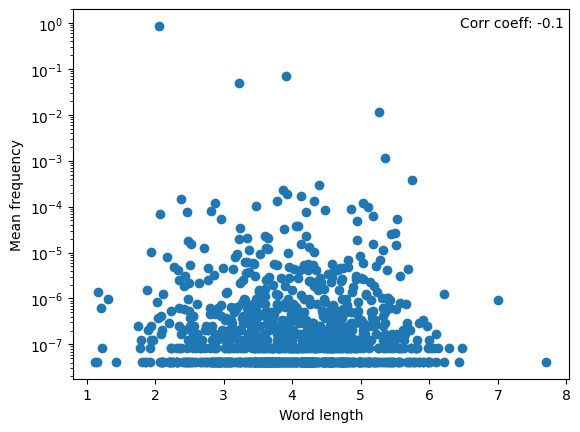

In [492]:
plt.scatter(y = freq_m, x = wm_m[1, :])
# add correlation coefficient on the top right corner
plt.text(0.78, 0.95, 'Corr coeff: {}'.format(np.round(np.corrcoef(freq_m, wm_m[1, :])[0, 1], 1)), transform=plt.gca().transAxes)
plt.yscale('log')
plt.xlabel('Word length')
plt.ylabel('Mean frequency')

In [493]:
freq_m.shape

(1000,)

Text(0, 0.5, 'Mean frequency')

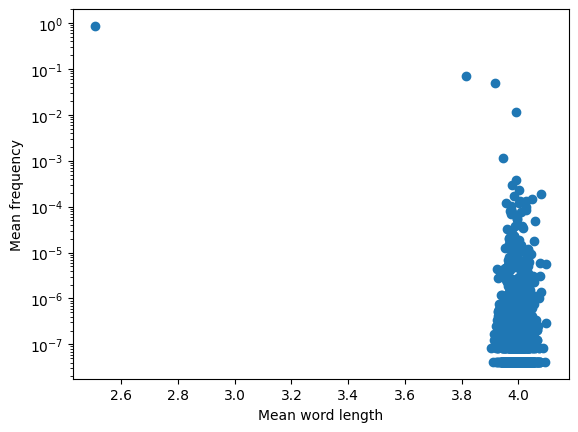

In [494]:
plt.scatter(y = freq_m, x = np.mean(wm_m, axis=0))
plt.yscale('log')
plt.xlabel('Mean word length')
plt.ylabel('Mean frequency')

In [495]:
np.corrcoef(freq_m, np.mean(wm_m, axis=0))[0, 1]

-0.827417264840211

In [496]:
outs = []
wm_ms = []

for _ in trange(10):
    out, wm_m, _ = model(selection=0.01, mutation_rate=0.2, detailed=True, sigma=1, mu=4)
    outs.append(out)
    wm_ms.append(wm_m)

  0%|          | 0/10 [00:00<?, ?it/s]

In [497]:
# plt.hist(np.random.choice(wm_ms[0].flatten(), size=1000, replace=False), alpha=0.1, color='black', bins=100, label='Model output')
# # kdeplot with counts
# plt.hist(np.random.choice(wm_ms[0].flatten(), size=1000, replace=False), alpha=0.1, color='red', bins=100, label='Model output')
# # kdeplot(np.random.normal(4, 1, 10000))
# plt.show()


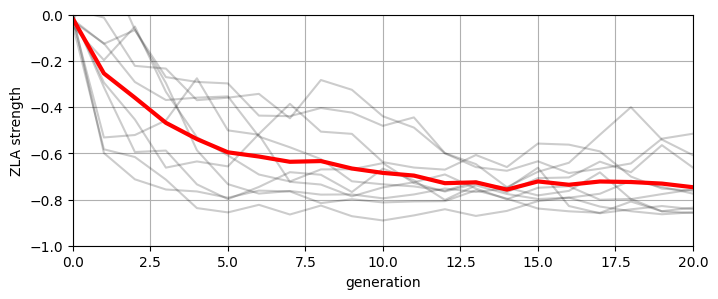

In [498]:
# plot out
plt.figure(figsize=(8, 3))
for _ in outs:
    plt.plot(_, alpha=0.2, color='black')
plt.plot(np.mean(outs, axis=0), color='red', linewidth=3, alpha=1)
plt.xlabel('generation')
plt.ylabel('ZLA strength')
plt.ylim(-1, 0)
plt.xlim(0, 20)
plt.grid()
plt.show()

In [439]:
selections = np.linspace(0.01, 1, 11)
mutation_rates = np.linspace(0.01, 1, 11)

results = np.zeros((len(selections), len(mutation_rates)))

# use tqdm
for i in trange(len(selections)):
    for j in range(len(mutation_rates)):
        results[i, j] = model(selections[i], mutation_rates[j], sigma=1, mu = 4)
        # results[i, j] = np.mean([model(selections[i], mutation_rates[j]) for _ in range(1)])

  0%|          | 0/11 [00:00<?, ?it/s]

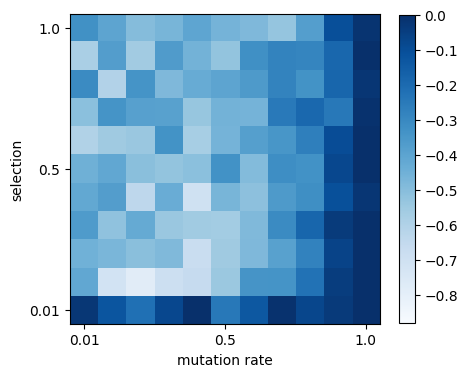

In [440]:
# plot the results as a heatmap
plt.figure(figsize=(5, 5))
plt.imshow(results, cmap='Blues')
plt.xlabel('mutation rate')
plt.ylabel('selection')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(mutation_rates))[::5], np.round(mutation_rates[::5], 2))
plt.yticks(np.arange(len(selections))[::5], np.round(selections[::5], 2))
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
plt.clim(0, -0.8)
plt.show()

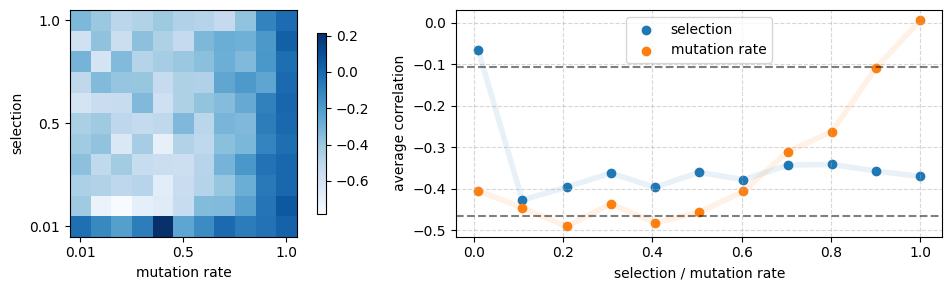

In [441]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1.2]})

# heatmap
im = ax1.imshow(results, cmap='Blues')
ax1.set_xlabel('mutation rate')
ax1.set_ylabel('selection')

# add xticks and yticks but display every 5th value
ax1.set_xticks(np.arange(len(mutation_rates))[::5])
ax1.set_xticklabels(np.round(mutation_rates[::5], 2))
ax1.set_yticks(np.arange(len(selections))[::5])
ax1.set_yticklabels(np.round(selections[::5], 2))
# reverse y axis ticks
ax1.invert_yaxis()
# Add colorbar
fig.colorbar(im, ax=ax1, shrink=0.8)

# scatter
ax2.scatter(selections, np.mean(results, axis=1), label='selection')
ax2.plot(selections, np.mean(results, axis=1), alpha=0.1, linewidth=4)
ax2.scatter(mutation_rates, np.mean(results, axis=0), label='mutation rate')
ax2.plot(mutation_rates, np.mean(results, axis=0), alpha=0.1, linewidth=4)
ax2.set_xlabel('selection / mutation rate')
ax2.set_ylabel('average correlation')
# add horizontal line at 0.1
ax2.axhline(-0.107, color='black', linestyle='--', alpha=0.5)
# add horizontal line at 0.5
ax2.axhline(-0.466, color='black', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(alpha=0.5, linestyle='--')

# Adjust vertical alignment
fig.subplots_adjust(bottom=0.2, top=0.8)

# Adjust horizontal alignment
fig.subplots_adjust(wspace=0.1)

plt.tight_layout()
plt.show()


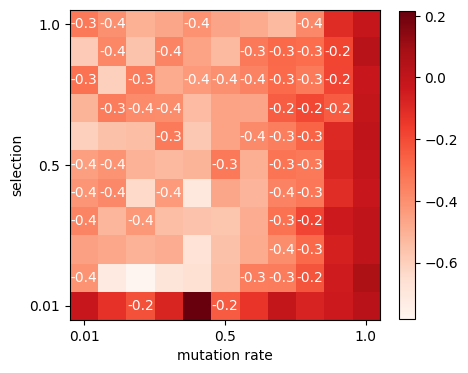

In [442]:
# plot the heatmap, but color cells if they are in between 0.1 and 0.5
plt.figure(figsize=(5, 5))
plt.imshow(results, cmap='Reds')
plt.xlabel('mutation rate')
plt.ylabel('selection')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(mutation_rates))[::5], np.round(mutation_rates[::5], 2))
plt.yticks(np.arange(len(selections))[::5], np.round(selections[::5], 2))
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
# add text to cells which are in between 0.1 and 0.5 with the correlation value rounded to 1 decimal
for i in range(len(selections)):
    for j in range(len(mutation_rates)):
        if  -0.107 >= np.round(results[i, j], 1) >= -0.466:
            plt.text(j, i, np.round(results[i, j], 1), ha='center', va='center', color='white')
plt.show()

In [448]:
# heatmap but for n_meaning and n_agents in ranges 10,100,1000, 10000 with mutation and selection at 0.5

n_agents_ = [10,100,1000,10000]
n_meaning_ = [10,100,1000,10000]

results_ = np.zeros((len(n_agents_), len(n_meaning_)))

for i in trange(len(n_agents_)):
    for n_meaning in n_meaning_:
        results_[n_agents_.index(n_agents_[i]), n_meaning_.index(n_meaning)] = model(0.5, 0.5, n_meanings=n_meaning, n_agents=n_agents_[i], sigma=1, mu=4)        

  0%|          | 0/4 [00:00<?, ?it/s]

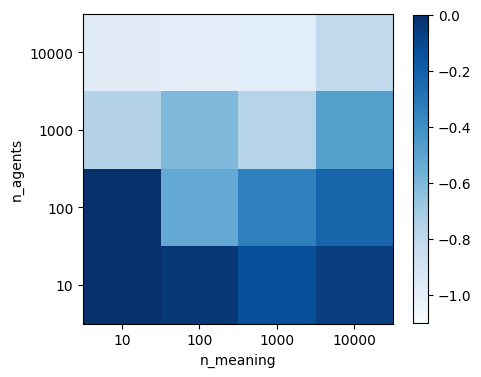

In [451]:
# plot the heatmap 
plt.figure(figsize=(5, 5))
plt.imshow(results_, cmap='Blues')
plt.xlabel('n_meaning')
plt.ylabel('n_agents')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(n_meaning_)), n_meaning_)
plt.yticks(np.arange(len(n_agents_)), n_agents_)
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
plt.clim(0, -1)
plt.show()